# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import numpy as np
import hydra
import copy
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=clsattack'])
    cfg.case.server.name = 'class_malicious_parameters'
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
ANTLR runtime and generated code versions disagree: 4.7.2!=4.8
Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.data.partition = "unique-class"
    cfg.case.user.user_idx = 32
    cfg.case.user.num_data_points = 2
    cfg.case.model = 'resnet18'
    cfg.case.server.model_state = 'trained'
    cfg.case.user.provide_labels = True
    cfg.case.user.provide_buffers = True
    cfg.case.user.provide_num_data_points = True

#     cfg.attack.regularization.total_variation.scale = 0.2
#     cfg.attack.regularization.total_variation.inner_exp = 2
#     cfg.attack.regularization.total_variation.outer_exp = 0.5
#     # cfg.attack.optim.signed = 'hard'
#     cfg.attack.optim.step_size_decay = 'cosine-decay'
#     cfg.attack.optim.warmup = 50
#     # cfg.attack.optim.step_size = 1e-2
#     cfg.attack.init = 'patterned-4'  # 'patterned-4'
#     cfg.attack.objective.task_regularization = .0
#     cfg.attack.regularization.features = .0
#     cfg.attack.regularization.total_variation.double_opponents = True
#     cfg.attack.regularization.deep_inversion = dict(scale=.0)

    cfg.attack.optim.max_iterations = 24000

### Instantiate all parties

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture resnet18 loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      39:1 for target shape [2, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 2

    Threat model:
    User provides labels: True
    User provides buffers: True
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 32
    
        
Server (of type ClassParameterServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: trained
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: double oppponents 

### Simulate an attacked FL protocol

True user data is returned only for analysis

In [5]:
# modify the model to catch the class we want
which_to_recover = 0
how_many = 1
how_many_rec = 1

# preparing for the attack
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
t_labels = shared_data['metadata']['labels'].cpu().detach().numpy()
cls_to_obtain = t_labels[which_to_recover:(which_to_recover + how_many)]
extra_info = {'cls_to_obtain': cls_to_obtain}

server.reset_model()
server.reconfigure_model('cls_attack', extra_info=extra_info)
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)
avg_feature = torch.flatten(server.reconstruct_feature(shared_data, cls_to_obtain))
feat_to_obtain = int(torch.argmax(avg_feature))
feat_value = float(avg_feature[feat_to_obtain])

extra_info['feat_to_obtain'] = feat_to_obtain
extra_info['feat_value'] = feat_value
extra_info['multiplier'] = 1
extra_info['non_target_logit'] = 0
extra_info['db_flip'] = 1

# iteratively get gradients back
recovered_single_gradients = server.binary_attack(user, extra_info)
server.reset_model()
extra_info['multiplier'] = 1
server.reconfigure_model('cls_attack', extra_info=extra_info)
server.reconfigure_model('feature_attack', extra_info=extra_info)

# reorder the gradients
attacker.objective.cfg_impl = cfg.attack.impl
single_gradients, single_losses = server.cal_single_gradients(attacker, true_user_data)
recovered_single_gradients = server.order_gradients(recovered_single_gradients, single_gradients)

In [6]:
server.reset_model()
extra_info['multiplier'] = 1
server.reconfigure_model('cls_attack', extra_info=extra_info)
server.reconfigure_model('feature_attack', extra_info=extra_info)

server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

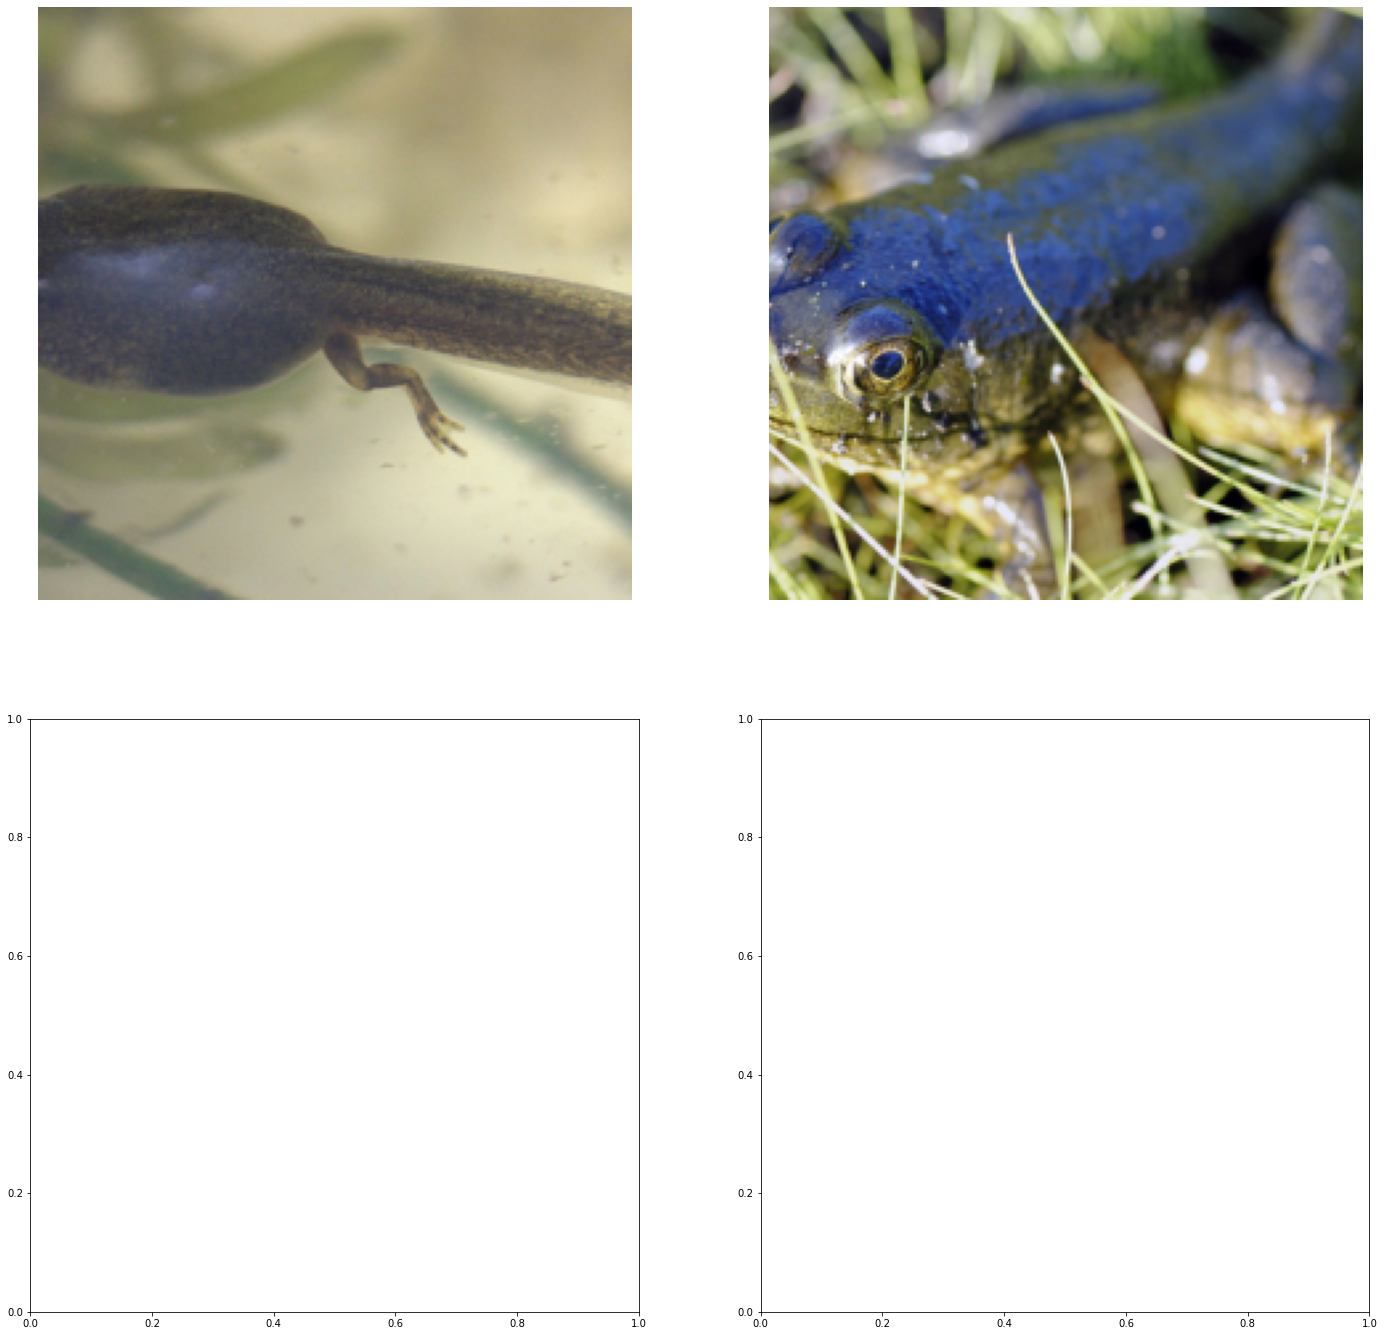

In [7]:
user.plot(true_user_data)

### Reconstruct user data:

In [8]:
tmp_share_data = copy.deepcopy(shared_data)
tmp_share_data['metadata']['num_data_points'] = how_many_rec
tmp_share_data['metadata']['labels'] = shared_data['metadata']['labels'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_share_data['gradients'] = recovered_single_gradients[which_to_recover]
tmp_true_user_data = {}
tmp_true_user_data['data'] = true_user_data['data'][which_to_recover:(which_to_recover + how_many_rec)]
tmp_true_user_data['labels'] = true_user_data['labels'][which_to_recover:(which_to_recover + how_many_rec)]

In [9]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [tmp_share_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.1190 |  Task loss: 12.3320 | T: 0.14s
| It: 1001 | Rec. loss: 0.3342 |  Task loss: 7.7445 | T: 42.07s
| It: 2001 | Rec. loss: 0.2873 |  Task loss: 8.3802 | T: 35.72s
| It: 3001 | Rec. loss: 0.2613 |  Task loss: 8.8369 | T: 36.09s
| It: 4001 | Rec. loss: 0.2872 |  Task loss: 8.6089 | T: 36.06s
| It: 5001 | Rec. loss: 0.2810 |  Task loss: 9.1665 | T: 36.68s
| It: 6001 | Rec. loss: 0.2782 |  Task loss: 9.1940 | T: 35.65s
| It: 7001 | Rec. loss: 0.2919 |  Task loss: 8.0627 | T: 36.62s
| It: 8001 | Rec. loss: 0.2765 |  Task loss: 8.6157 | T: 36.02s
| It: 9001 | Rec. loss: 0.2797 |  Task loss: 7.9175 | T: 36.00s
| It: 10001 | Rec. loss: 0.2967 |  Task loss: 7.9057 | T: 36.01s
| It: 11001 | Rec. loss: 0.3507 |  Task loss: 7.1931 | T: 35.84s
| It: 12001 | Rec. loss: 0.2339 |  Task loss: 8.9655 | T: 36.03s
| It: 13001 | Rec. loss: 0.1942 |  Task loss: 8.7414 | T: 35.78s
| It: 14001 | Rec. loss: 0.1944 |  Task loss: 9.1286 | T: 36.22s
| It: 15001 | Rec. loss: 0.1677 |  Tas

In [10]:
#How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, tmp_true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

D:\anaconda\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


METRICS: | MSE: 0.0265 | PSNR: 15.76 | FMSE: 2.9111e+00 | LPIPS: 0.31|
 R-PSNR: 16.00 | IIP-pixel: 100.00% | SSIM: 0.4573 | Label Acc: 100.00%


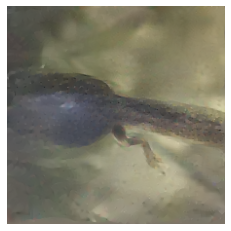

In [11]:
user.plot(reconstructed_user_data)

In [12]:
for i in range(len(recovered_single_gradients)):
    grad_0 = torch.cat([torch.flatten(i) for i in recovered_single_gradients[i]])
    grad_0_0 = single_gradients[i]
    
    print(float(torch.nn.CosineSimilarity(dim=0)(grad_0, grad_0_0).detach()))

0.9875911474227905
0.9837332367897034
